<a href="https://colab.research.google.com/github/ExplorerGumel/Quora-insincere-questions-text-sentiment/blob/main/Quora_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler
import zipfile
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# The datasets are available as zip files, so here i extract them to my drive.

local_zip ='/content/Quora_train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/MyDrive/Quora_setiment/')
zip_ref.close()

local_zip ='/content/Quora_test.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/MyDrive/Quora_setiment/')
zip_ref.close()

local_zip ='/content/Quora_ss.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/MyDrive/Quora_setiment/')
zip_ref.close()

In [2]:
train = pd.read_csv("/content/drive/MyDrive/Quora_setiment/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Quora_setiment/test.csv")
test_labels = pd.read_csv("/content/drive/MyDrive/Quora_setiment/sample_submission.csv")

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [3]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
print(f"Maximum sequence length: {train.question_text.apply(len).max()}")
print(f"Most frequent sequence length: {train.question_text.apply(len).mode()[0]}")
print(f"Mean sequence length: {train.question_text.apply(len).mean()}")

Maximum sequence length: 1017
Most frequent sequence length: 48
Mean sequence length: 70.67883551459971


<Axes: title={'center': 'Histogram of question length'}, ylabel='Frequency'>

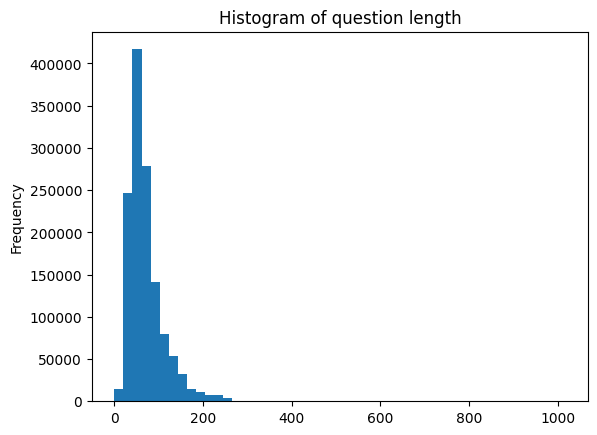

In [5]:
train.question_text.apply(len).plot(kind='hist', bins=50, title="Histogram of question length")

<Axes: title={'center': 'Count of target label'}>

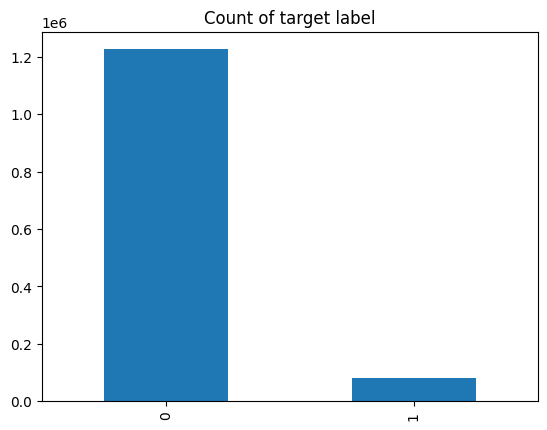

In [8]:
train.target.value_counts().plot(kind='bar', title="Count of target label")
# As seen insincere questions are almost 10% of the data only(which will likely result in imbalance in classification). An appropriate
# will later be induced

In [7]:
#set maxlen based on right edge of question length histogram 
maxlen = 250

#arbitrary choice of top 25000 words
max_features=25000

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, 
                                                  oov_token="<oov>", 
                                                  filters='"!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n"',
                                                  split=" ")

tokenizer.fit_on_texts(train.question_text)
train_df = tokenizer.texts_to_sequences(train.question_text)
train_df = tf.keras.preprocessing.sequence.pad_sequences(train_df, maxlen=maxlen, padding="post", truncating='post')

In [9]:
train_len = int(train_df.shape[0] * 0.7)

X_train = train_df[0:train_len]
Y_train = train.target[0:train_len]

X_val = train_df[train_len:]
Y_val = train.target[train_len:]

In [10]:
#balance data on train set
rus = RandomUnderSampler(random_state=42)
X_balance, Y_balance = rus.fit_resample(X_train, Y_train.values)
X_vals, Y_vals = rus.fit_resample(X_val, Y_val)

In [11]:
# Model training takes longer to train therefore i decide to cast their dtypes to float16 and int16 respectively 

X_bal = tf.cast(X_balance,dtype=tf.float16)
Y_bal = tf.cast(Y_balance,dtype=tf.int16)
X_vals = tf.cast(X_vals,dtype=tf.float16)
Y_vals = tf.cast(Y_vals,dtype=tf.int16)

In [12]:
vocab_size = 25000
embedding_dim = 32
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 32)           800000    
                                                                 
 batch_normalization (BatchN  (None, 250, 32)          128       
 ormalization)                                                   
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 24)               9

In [14]:
METRICS = [
    tf.keras.metrics.AUC(name='roc-auc'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name="recall")
          ]
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=METRICS)

num_epochs = 30

# Train the model
history = model.fit(X_bal, Y_bal, epochs=num_epochs, validation_data=(X_vals, Y_vals))



Epoch 1/30
3532/3532 [==============================] - 51s 14ms/step - loss: 0.3432 - roc-auc: 0.9293 - accuracy: 0.8634 - precision: 0.8553 - recall: 0.8748 - val_loss: 0.6520 - val_roc-auc: 0.9287 - val_accuracy: 0.7799 - val_precision: 0.9393 - val_recall: 0.5985
Epoch 2/30
3532/3532 [==============================] - 37s 10ms/step - loss: 0.3296 - roc-auc: 0.9343 - accuracy: 0.8700 - precision: 0.8627 - recall: 0.8801 - val_loss: 0.4546 - val_roc-auc: 0.9362 - val_accuracy: 0.7872 - val_precision: 0.7098 - val_recall: 0.9717
Epoch 3/30
3532/3532 [==============================] - 28s 8ms/step - loss: 0.3242 - roc-auc: 0.9365 - accuracy: 0.8729 - precision: 0.8655 - recall: 0.8831 - val_loss: 0.4074 - val_roc-auc: 0.9404 - val_accuracy: 0.8240 - val_precision: 0.7536 - val_recall: 0.9627
Epoch 4/30
3532/3532 [==============================] - 29s 8ms/step - loss: 0.3200 - roc-auc: 0.9382 - accuracy: 0.8745 - precision: 0.8667 - recall: 0.8851 - val_loss: 2.1240 - val_roc-auc: 0.829

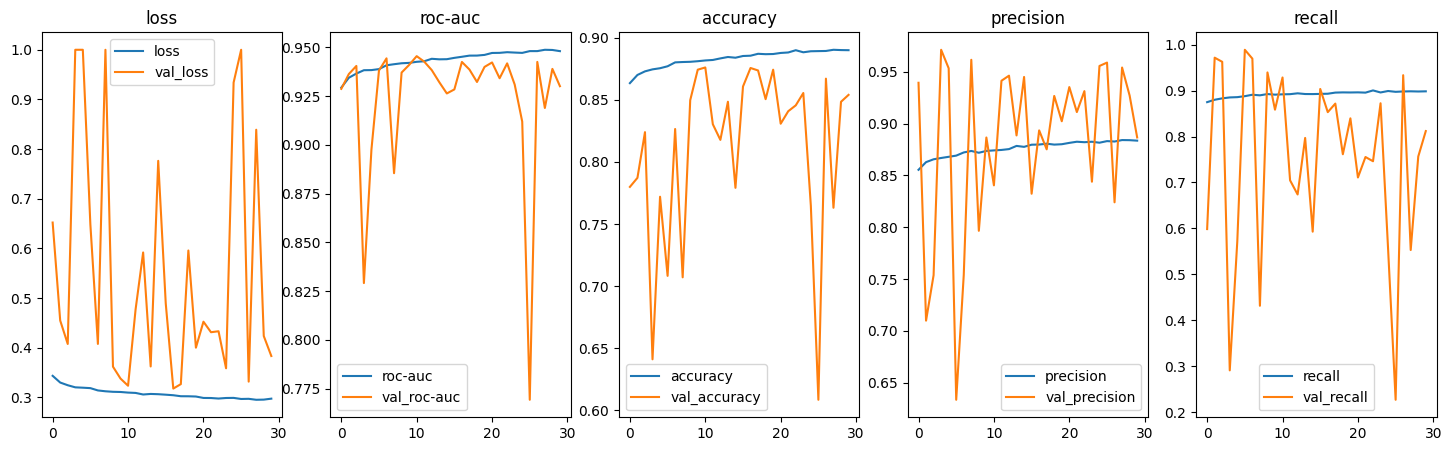

In [16]:
def plot(history, *metrics):
    
    n_plots = len(metrics)
    
    fig, axs = plt.subplots(1,n_plots, figsize=(18, 5))

    hist = history.history

    for ax, metric in zip(axs, metrics):
        ax.plot(np.clip(hist[metric], 0, 1))
        ax.plot(np.clip(hist["val_"+metric], 0, 1))
        ax.legend([metric, "val_" + metric])
        ax.set_title(metric)
plot(history, 'loss', 'roc-auc', 'accuracy', 'precision', "recall")

In [22]:
# Now let's get the output of our last layer inorder to project it on TensorflowBoard

embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape) 

# Get the index-word dictionary
reverse_word_index = tokenizer.index_word


(25000, 32)


In [24]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()



In [25]:
# Import files utilities in Colab
try:
  from google.colab import files
except ImportError:
  pass

# Download the files
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>